# Маркетинговый анализ развлекательного приложения *Procrastinate Pro+*

Последние несколько месяцев несмотря на огромные вложения в рекламу, приложение Procrastinate Pro+ не приносит прибыли, компания терпит убытки. Наша `задача` - понять почему это происходит и помочь компании выйти в плюс.


В нашем распоряжении 3 датасета. Данные о пользователях, привлеченных с 1 мая по 27 октября 2019 года:
- **лог сервера с данными об их посещениях**(`visits_info_short.csv`),
- **выгрузка их покупок за этот период**(`orders_info_short.csv`),
- **рекламные расходы**(`costs_info_short.csv`).

Изучим:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.


###  Загружаем данные и готовим их к анализу

In [55]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [56]:
try:
    visits = pd.read_csv('datasets/visits_info_short.csv')
except:
    visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')

In [57]:
try:
    orders = pd.read_csv('datasets/orders_info_short.csv')
except:
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')

In [58]:
try:
    costs = pd.read_csv('costs_info_short.csv')
except:
    costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')

In [59]:
visits.head(5)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [60]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Структура **`visits_info_short.csv`**:
- `User Id` — уникальный идентификатор пользователя,
- `Region` — страна пользователя,
- `Device` — тип устройства пользователя,
- `Channel` — идентификатор источника перехода,
- `Session Start` — дата и время начала сессии,
- `Session End` — дата и время окончания сессии.

In [61]:
orders.head(5)

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [62]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Структура **`orders_info_short.csv`**:
- `User Id` — уникальный идентификатор пользователя,
- `Event Dt` — дата и время покупки,
- `Revenue` — сумма заказа.

In [63]:
costs.head(5)

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [64]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Структура **`costs_info_short.csv`**:
- `dt` — дата проведения рекламной кампании,
- `Channel` — идентификатор рекламного источника,
- `costs` — расходы на эту кампанию.

#### Предобработка данных

In [65]:
# приведем названия столбцов к нижнему регистру
visits.columns = visits.columns.str.lower()
# проверим, как изменились названия
visits.columns

Index(['user id', 'region', 'device', 'channel', 'session start',
       'session end'],
      dtype='object')

In [66]:
visits = visits.rename(columns={'user id' : 'user_id', 'session start': 'session_start', 'session end':'session_end'})
visits.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

In [67]:
# приведем названия столбцов к нижнему регистру
orders.columns = orders.columns.str.lower()
# проверим, как изменились названия
orders.columns

Index(['user id', 'event dt', 'revenue'], dtype='object')

In [68]:
orders = orders.rename(columns={'user id' : 'user_id', 'event dt': 'event_dt'})
orders.columns

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

In [69]:
# приведем названия столбцов к нижнему регистру
costs.columns = costs.columns.str.lower()
# проверим, как изменились названия
costs.columns

Index(['dt', 'channel', 'costs'], dtype='object')

Пропусков в датафреймах не обнаружено, изучим данные на наличие дубликатов:

In [70]:
visits.duplicated().sum()

0

In [71]:
orders.duplicated().sum()

0

In [72]:
costs.duplicated().sum()

0

Пропуски и явные дубликаты в данных отсутствуют. 


Далее иземним типы данных некоторых столбцов:
- `session_start` и `session_end` таблицы visits 
- `Event Dt` из датафрейма orders
- и `dt` из costs

переведем из `object` к формату `datetime` 


In [73]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 
costs['month'] = pd.to_datetime(costs['dt']).dt.month
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week

Проведена предобработка данных: мы изучили основную информацию о датафремах, првели названия колонок к нужному виду, привели данные к верному типу, убедились в отсутсвии пропусков и дубликатов.
В последующих шагах изучим:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

### Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Зададим функции, необходимые для дальнейшего анализа.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

#### Функция для `создания пользовательских профилей`

In [74]:
def get_profiles(sessions, orders, ad_costs):

    # сортируем сессии по ID пользователя и дате посещения
    # группируем по ID и находим первые значения session_start и channel
    # столбец с временем первого посещения назовём first_ts
    # от англ. first timestamp — первая временная отметка
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg({'session_start': 'first', 'channel': 'first', 'device': 'first',
                'region': 'first',})
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

#### Функция для `расчёта удержания` (Retention Rate)

In [75]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### Функция для `расчёта конверсии`

In [76]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### Функция для `расчёта LTV  и ROI` 

In [77]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

#### Функция для `сглаживания данных`

In [78]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

#### Функция для `визуализации удержания` (построение графика Retention Rate)

In [79]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

#### Функция для `визуализации конверсии`

In [80]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

#### Функция для `визуализации LTV и ROI`

In [81]:

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


Созданы функции для создания пользовательских профилей, для расчета и анализа LTV (Lifetime Value, «пожизненная ценность» клиента), ROI (Return On Investment, окупаемость инвестиций), Retention Rate (коэффициент удержания) и Conversion Rate (коэффициент конверсии).

`LTV` - общая сумма денег, которую один клиент в среднем приносит компании со всех своих покупок.

`ROI` - показывает, на сколько процентов LTV превысил CAC(Customer Acquisition Cost, стоимость привлечения одного клиента). Ещё говорят: на сколько процентов «окупились» клиенты.

`Retention Rate` показывает, как долго клиенты остаются с компанией.

`CR` - отношение числа пользователей, совершивших целевое действие ко всем пользователям.


### Исследовательский анализ данных

#### Составим профили пользователей.  Определим минимальную и максимальную даты привлечения пользователей.

In [82]:
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-07 20:58:57,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-09 12:46:07,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01 09:58:33,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-22 21:35:48,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-02 00:07:44,False,0.230769


In [83]:
costs.groupby('channel').agg({'dt': 'min'}).head(1)

,dt
channel,
AdNonSense,2019-05-01


In [84]:
costs.groupby('channel').agg({'dt': 'max'}).head(1)

,dt
channel,
AdNonSense,2019-10-27


Перед нами данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года.
Установим момент и горизонт анализа данных. Предположим, что на календаре 1 ноября 2019 года, и зададим 2-недельный горизонт анализа.

In [85]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

Составили профили пользователей, в каждом из которых получили данные о посещениях сайта (дата и время, рекламный источник, используемое устройство, информация о регионе), о заказах, информацию о расходах на рекламу и даты проведения рекламных кампаний. Что значительно упрощают дальнейший анализ.
Кроме того, определили интервал привлечения пользователей, установили горизонт и момент анализа данных.

#### Определим динамику привлечения новых пользователей по регионам. Выясним, как распределяются показатели платежеспособности пользователей по странам. 


Имея готовые профили пользователей, легко узнать распределение пользователей по регионам. Сгруппируем пользователей по региону и посчитаем колическво уникальных id:

In [86]:
profiles.groupby('region').agg({'user_id': 'nunique'})

,user_id
region,
France,17450
Germany,14981
UK,17575
United States,100002


In [87]:
# определим долю пользователей
profiles.groupby('region').agg({'user_id': 'nunique'})/profiles.agg({'user_id': 'count'})

,user_id
region,
France,0.116327
Germany,0.099868
UK,0.117160
United States,0.666644


Для наглядности построим график, отображающий динамику привлечения новых пользователей по каждой стране.

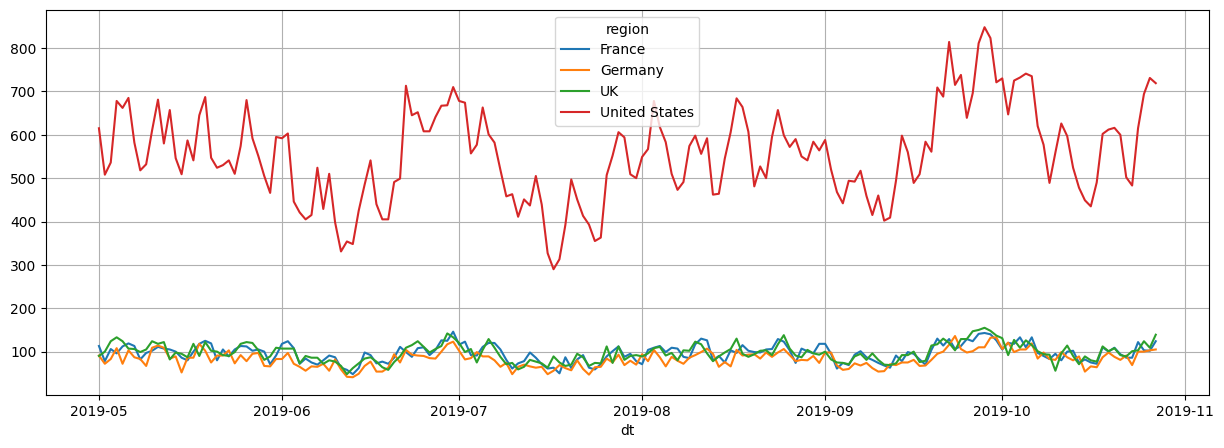

In [88]:
profiles.pivot_table(
    index='dt',  # даты первых посещений
    columns='region',  # источники переходов
    values='user_id',  
    aggfunc='nunique'  
).plot(figsize=(15, 5), grid=True)

plt.show()

Определим долю платящих пользователей по регионам:

In [89]:
 profiles.groupby('region').agg({'payer':'mean'}).sort_values(by='payer', ascending=False)

,payer
region,
United States,0.069019
Germany,0.041119
UK,0.039829
France,0.037994


Выяснили, что пользователей из США 100002, что в 10 раз больше, чем в остальных странах и составляет ~76%: 17575(около 12%) из Великобритании, 17450(примерно 12%) из Франции, 14981(10%) из Германии. 

Аналогичная ситуация с количеством платящих пользователей по регионаими: большая доля приходится на пользователей из США, платежеспособность клиентов из Германии и Соединенного Королевства примерно на равных, меньше всего покупок совершают пользователи из Франции.

####  Определим, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.


In [90]:
# определим, какими устройствами пользуются клиенты и долю платящих пользователей по каждому устройству
device_t = profiles.groupby('device').agg({'user_id': 'nunique', 'payer':'mean'})\
            .sort_values(by='payer', ascending=False)
device_t

,user_id,payer
device,,
Mac,30042,0.063644
iPhone,54479,0.062079
Android,35032,0.058518
PC,30455,0.050468


Исходя из полученных данных, большая часть пользователей приложения используют устройства на *Android (35032 пользователей)*, вторые по количеству - пользователи с *Mac устройствами(30042)*, за ними следуют пользователи с *PC(30455)*, меньше всего приложение используют с *iPhone*.

При этом, покупательская способность пользователей в зависимости от устройств, отличается от выше указанного распределения: наибольшее число покупок совершают пользователи с устройств *Mac (6%)*, примерно столько же покупок происходит с *iPhone*, чуть меньше покупок совершают пользователи *Android* устройств и минимальная доля платящих пользователей используют *PC* устройства.

#### Определим каналы, из которых пришло больше всего платящих пользователей, а так же изучим рекламные источники привлечения. 

In [91]:
# определим, какими устройствами пользуются клиенты и долю платящих пользователей по каждому устройству
chanel_t = profiles.groupby('channel').agg({'user_id': 'nunique', 'payer':'mean'})\
    .sort_values(by='payer', ascending=False)
chanel_t


,user_id,payer
channel,,
FaceBoom,29144,0.122049
AdNonSense,3880,0.113402
lambdaMediaAds,2149,0.104700
TipTop,19561,0.096007
RocketSuperAds,4448,0.079137
WahooNetBanner,8553,0.052964
YRabbit,4312,0.038265
MediaTornado,4364,0.035747
LeapBob,8553,0.030633


По количеству привлеченных пользователей среди рекламных источников лидируют *органические пользователи (56439 пользователей)*, при этом их покупательская способность - минимальная *(2%)*, на втором месте *FaceBoom - 29144 пользователей*, с самым высокой долей платящих пользователей *(12%)*, далее следует *TipTop (19561 пользователей - <1%)*, в то время как пользователи, пришедшие из *AdNonSense, lambdaMediaAds* несмотря на свою немногочисленность, имеют хороший показатель покупательской активности *(11% b 10% соответственно)*.




На данном этапе мы создали профили пользователей, оценили динамику привлечения пользователей по регионам, в зависимости от используемых устройств и каналов привлечения, а так же определили долю покупающих пользователей по тем же категориям. Большое количество пользователей не всегда равно высокая доля покупающих пользователей. 
Так, например, выяснили, что пользователей из США 100002, что в 10 раз больше, чем в остальных странах и составляет ~76%: 17575(около 12%) из Великобритании, 17450(примерно 12%) из Франции, 14981(10%) из Германии. Ситуация с долей платязщих пользователей аналогична.

Большая часть пользователей приложения используют устройства на Android (35032 пользователей), вторые по количеству - пользователи с Mac устройствами(30042), за ними следуют пользователи с PC(30455), меньше всего приложение используют с iPhone. При этом, наибольшее число покупок совершают пользователи с устройств Mac (6%), примерно столько же покупок происходит с iPhone, чуть меньше покупок совершают пользователи Android устройств и минимальная доля платящих пользователей используют PC устройства.

По количеству привлеченных пользователей среди рекламных источников лидируют органические пользователи (56439 пользователей), при этом их покупательская способность - минимальная (2%), на втором месте FaceBoom - 29144 пользователей, с самым высокой долей платящих пользователей (12%), далее следует TipTop (19561 пользователей - <1%), в то время как пользователи, пришедшие из AdNonSense, lambdaMediaAds несмотря на свою немногочисленность, имеют хороший показатель покупательской активности (11% b 10% соответственно).

Что указывет на то, что покупательские способности зависят от других факторов, изучением которых мы займемся в последубщих шагах.

### Маркетинг

#### Посчитаем общую сумму расходов на маркетинг.

In [92]:
total = profiles['acquisition_cost'].sum().round(2)
display("Общая сумма расходов на маркетинг", total)

'Общая сумма расходов на маркетинг'

105497.3

#### Определим распределение трат по рекламным источникам

In [93]:
chanel_cost = profiles.groupby('channel').agg({'acquisition_cost': 'sum'}).sort_values(by='acquisition_cost', ascending=False)
chanel_cost['%'] = round(chanel_cost['acquisition_cost'] /total, 2)*100
chanel_cost


,acquisition_cost,%
channel,,
TipTop,54751.30,52.0
FaceBoom,32445.60,31.0
WahooNetBanner,5151.00,5.0
AdNonSense,3911.25,4.0
OppleCreativeMedia,2151.25,2.0
RocketSuperAds,1833.00,2.0
LeapBob,1797.60,2.0
lambdaMediaAds,1557.60,1.0
MediaTornado,954.48,1.0


Более половины рекламного бюждета компания тратит на источник *TipTop	(54751.30)*, *FaceBoom* на втором месте по тратам(сумма *32445.60*), третий по сумме трат источник *WahooNetBanner (5151)*, так же выделили группу *органических пользователей*, которые пришли в приложение без целеноправленных вложений компании, затраты на их привлечение 0, меньше всего компания вкладывает в рекламу через каналы *MediaTornado (954.48) и YRabbit (944.22)*.

####  Провизуализируем динамику изменения расходов во времени по каждому источнику.


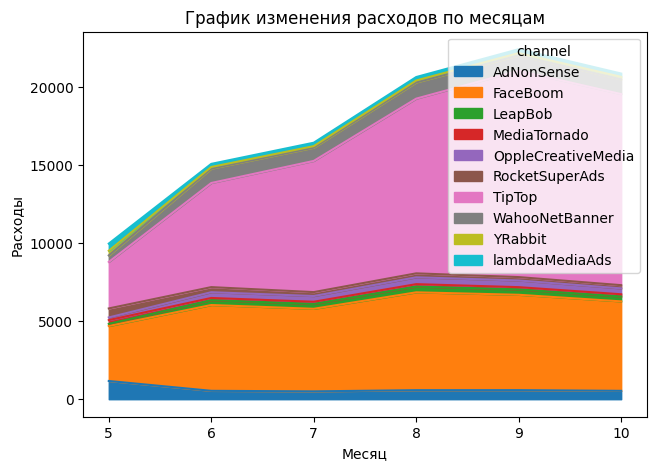

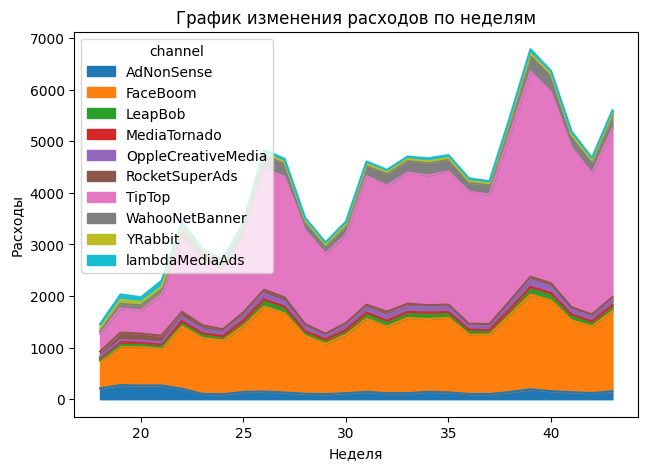

In [94]:
plt.subplots(figsize = (16, 5))
costs.pivot_table(
    index='month',  # даты 
    columns='channel',  # источники
    values='costs',  
    aggfunc='sum',  
).plot.area(ax = plt.subplot(1, 2, 1))
plt.title('График изменения расходов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Расходы')
plt.show() 

plt.subplots(figsize = (16, 5))
costs.pivot_table(
    index='week',   
    columns='channel',  
    values='costs',  
    aggfunc='sum',  
).plot.area(ax = plt.subplot(1, 2, 2))
plt.title('График изменения расходов по неделям')
plt.xlabel('Неделя')
plt.ylabel('Расходы')
plt.show();

Динамика изменения расходов изменяется для всех источников синхронно и соразмерно расходам, которые компания вкладывает в привлечение пользователей через определенный канал. Расходы на рекламу растут с мая по сентябрь с периодически встречающимися пиковыми начениями на 21-22 неделе, 26-27 неделе и самыми большими расходами рекламного бюджета в 39-40 неделю.

#### Определим, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. 

In [95]:
# средний CAC по каналам привлечения
cac = (
    profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
    .sort_values(by='cac', ascending=False)
)
round(cac, 2)

,cac
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


In [96]:
# средний CAC по всему проекту без органических пользователей
profiles[profiles.channel != 'organic']
cac_avg = (profiles.agg({'acquisition_cost': 'mean'}))
round(cac_avg, 2)

acquisition_cost    0.7
dtype: float64

Привлечение пользователя из канала *TipTop* более чем в 2 раза превышает затраты на привлечения пользователя из других каналов *(и составляет 2.8)*,  привлечение одного пользователя из канала FaceBoom в среднем обходится компании *1.11, AdNonSense - 1.01, lambdaMediaAds - 0.72*, меньшую сумму на привлечение пользователя в приложение компания тратит на каналы *MediaTornado, YRabbit(0.22), LeapBob	(0.21).* При этом, что средняя стоимость привлечения одного клиента(без учета органических пользователей) равна 0.7.

**Вывод**

Общая сумма расходов на маркетинг составила 105497.3 ед. Более половины рекламного бюждета компания тратит на источник TipTop (54751.30), FaceBoom на втором месте по тратам(сумма 32445.60), третий по сумме трат источник WahooNetBanner (5151), так же выделили группу органических пользователей, которые пришли в приложение без целеноправленных вложений компании, затраты на их привлечение 0, меньше всего компания вкладывает в рекламу через каналы MediaTornado (954.48) и YRabbit (944.22).
 Каждый месяц с мая по сентябрь расходы на маркетинг возрастают.

Привлечение пользователя из канала TipTop более чем в 2 раза превышает затраты на привлечения пользователя из других каналов (и составляет 2.8), привлечение одного пользователя из канала FaceBoom в среднем обходится компании 1.11, AdNonSense - 1.01, lambdaMediaAds - 0.72, меньшую сумму на привлечение пользователя в приложение компания тратит на каналы MediaTornado, YRabbit(0.22), LeapBob (0.21).
Стоимость привлечения органических пользователей во всех когортах, распределенных по каналам, равна нулю.

### Оценим окупаемость рекламы

#### Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. 

Исключим органических пользователей из анализа.

In [97]:
profiles = profiles.query('channel != "organic"')

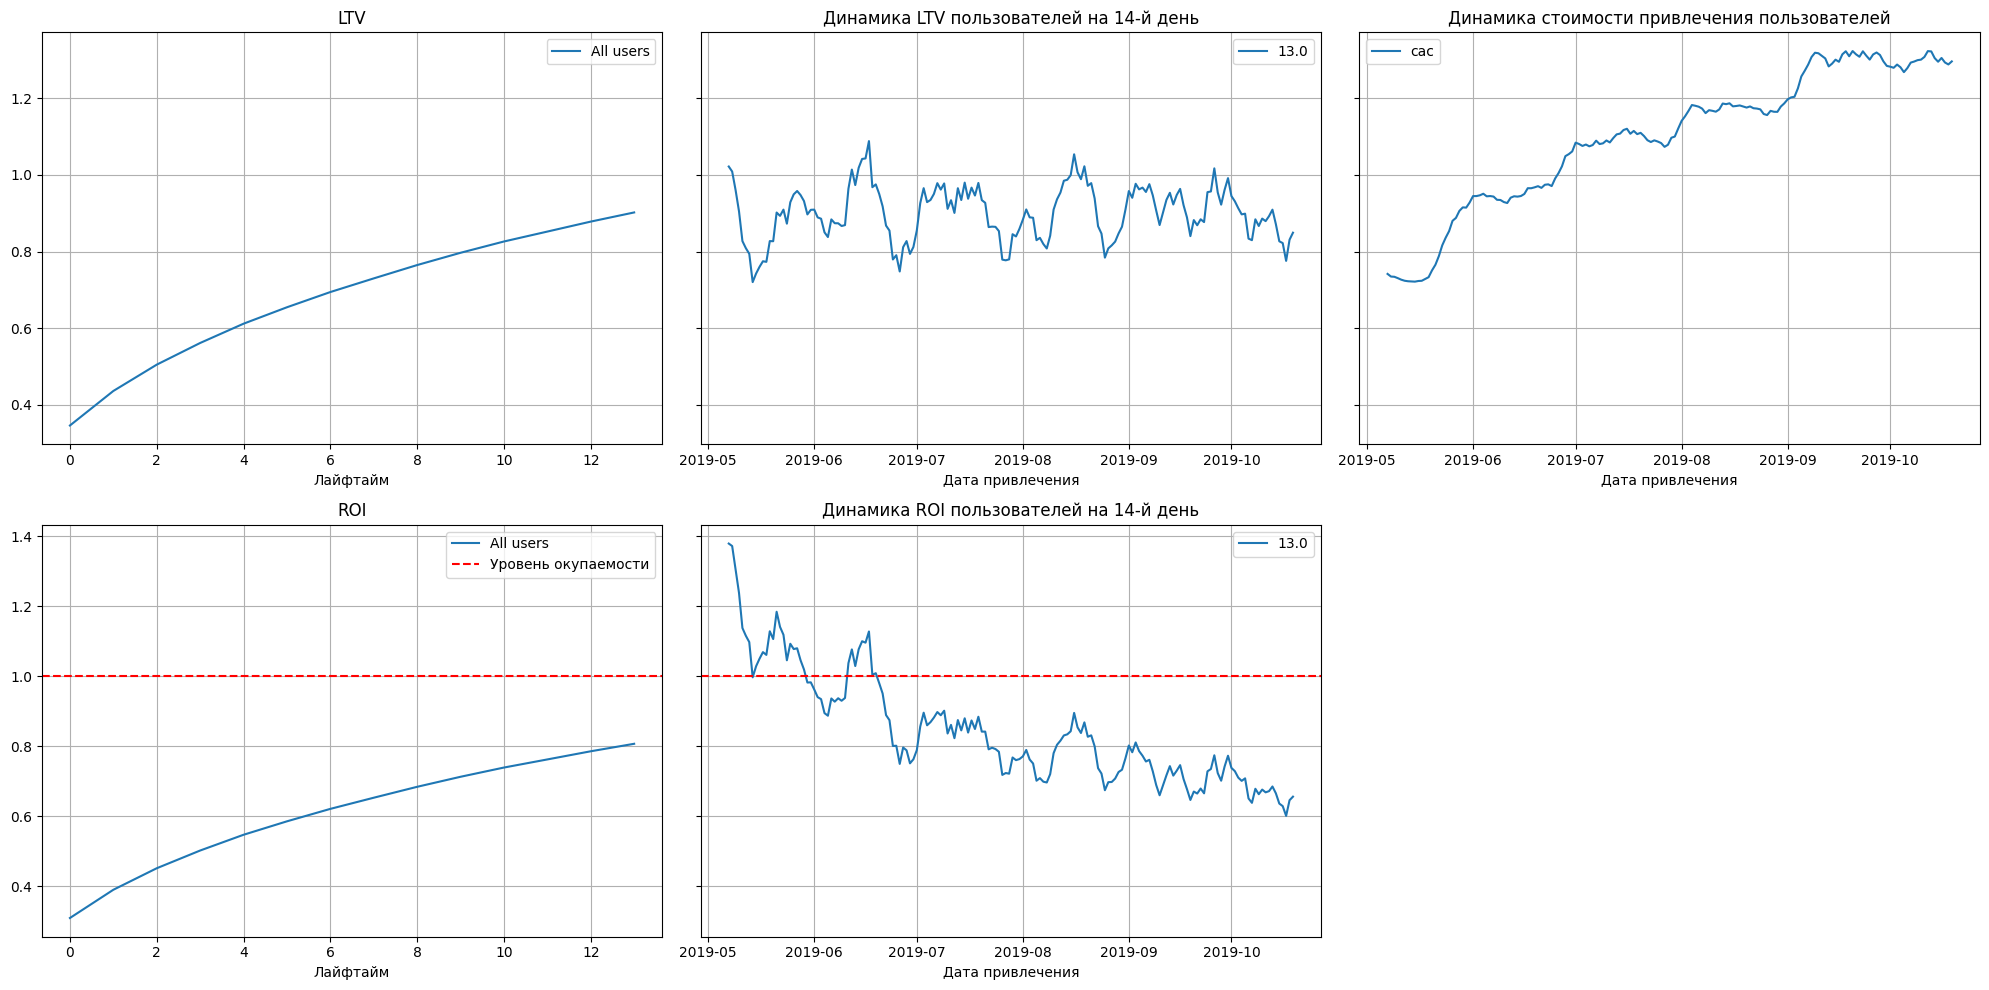

In [98]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)

# построим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать такие выводы:

- Реклама не окупается. ROI в конце второй недели — чуть выше 80%.
- Вероятно, дело в увеличении рекламного бюджета, отмечаем рост CAC. 
- Показатель LTV достаточно стабилен. Значит, дело не в ухудшении качества пользователей.


Чтобы разобраться в причинах, пройдём по всем доступным характеристикам пользователей — стране, источнику и устройству первого посещения.

#### Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. 

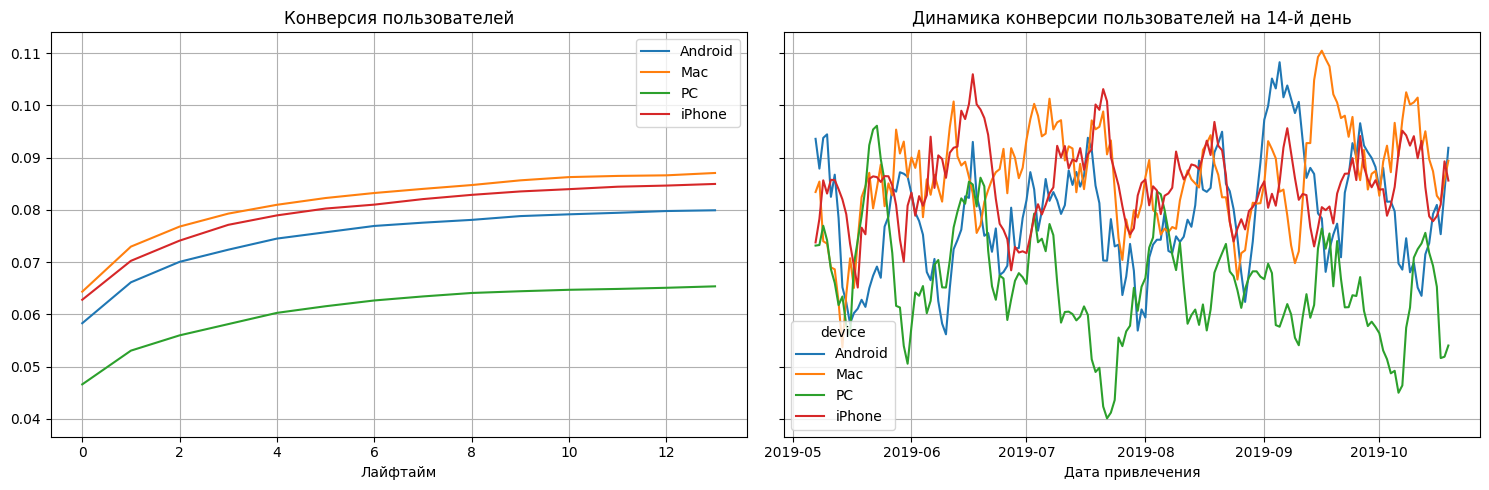

In [99]:
# смотрим конверсию с разбивкой по устройствам
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Судя по графикам, пользователи Mac и iPhone конвертируются очень хорошо, причём постоянно. Видимо, дело в удержании. Вызовем функции `get_retention()` и `plot_retention()`, чтобы рассчитать и отразить на графиках этот показатели.

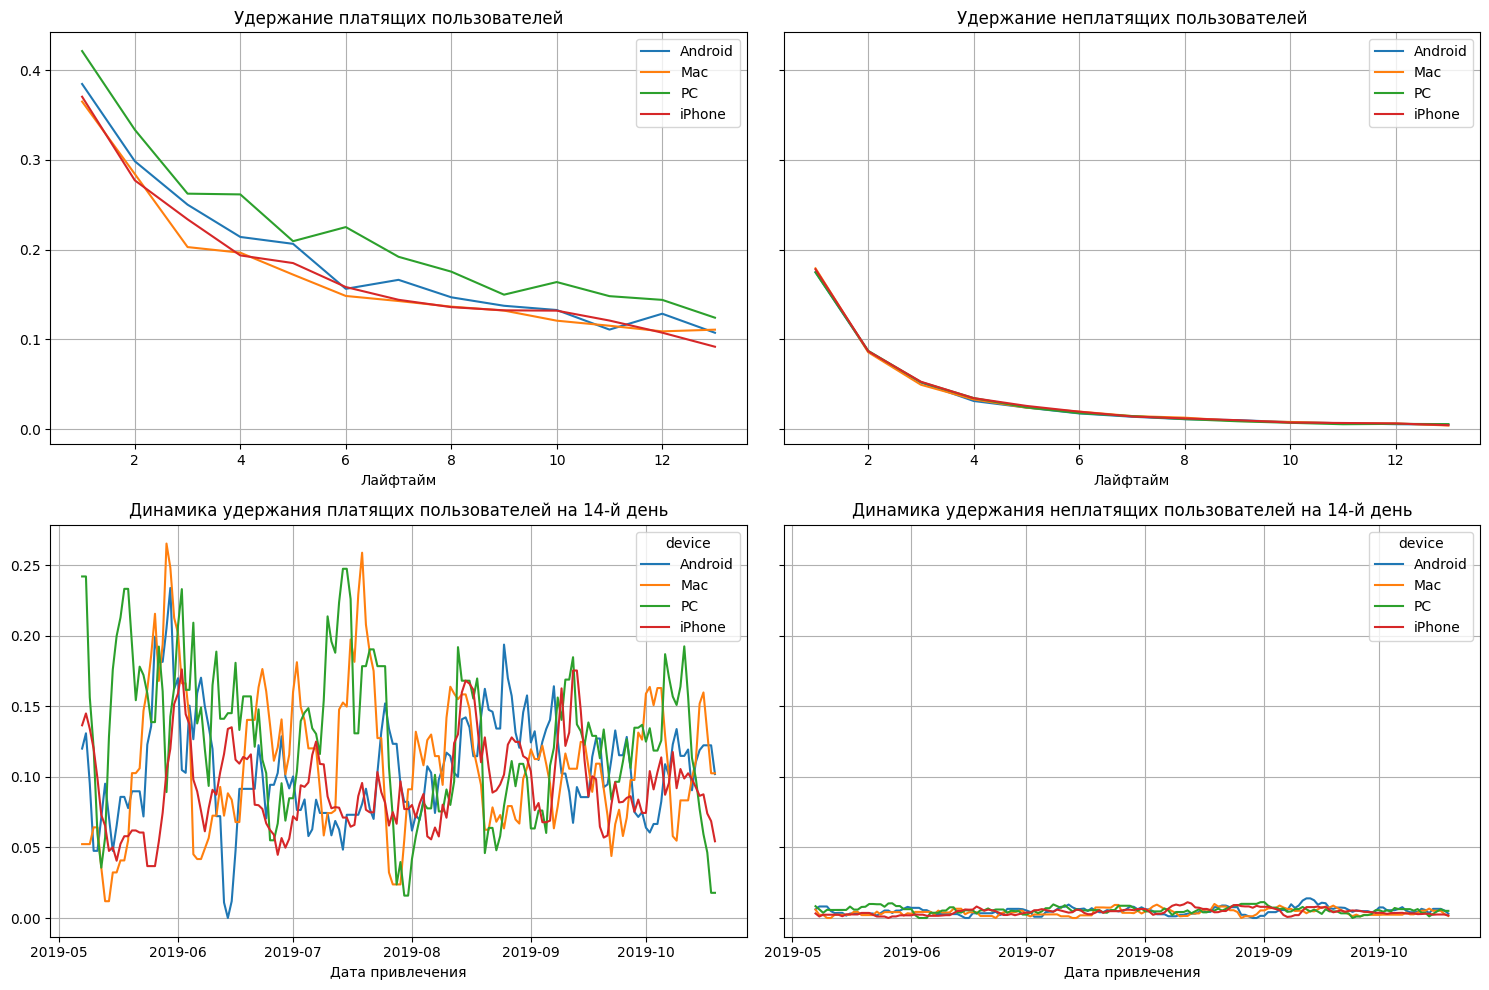

In [100]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Действительно, пользователи Mac и iPhone стабильно плохо удерживаются.Чуть лучше динамика удержания платящих пользователей у PC, однако для всех устройств к 14 дню она немного превышает 10%. Это очень низкий показатель.
Скорее всего, причина в какой-нибудь технической проблеме или в неоправданных ожиданиях пользователей, сложившихся после рекламной кампании. Стоит провести технический анализ приложения и, возможно, пересмотреть рекламу.

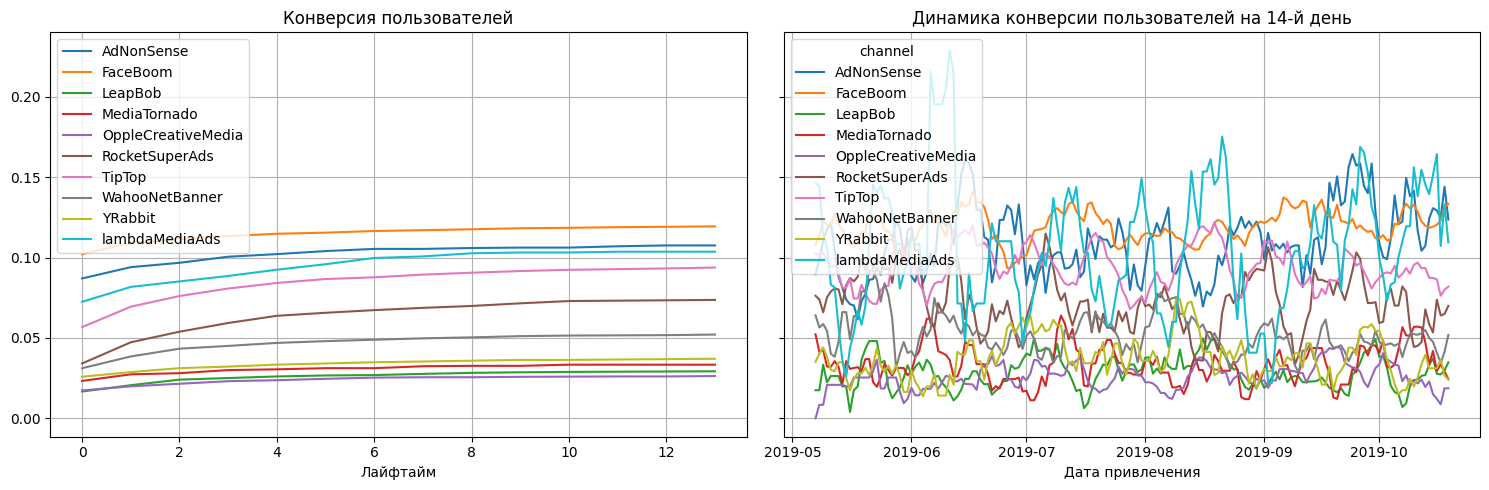

In [101]:
# смотрим конверсию с разбивкой по каналам
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

В разбивке по каналам, лучшая конверсия у FaceBoom, AdNonSense и lambdaMediaAds. Посмотрим удержание пользователей с разбивкой по каналам. 

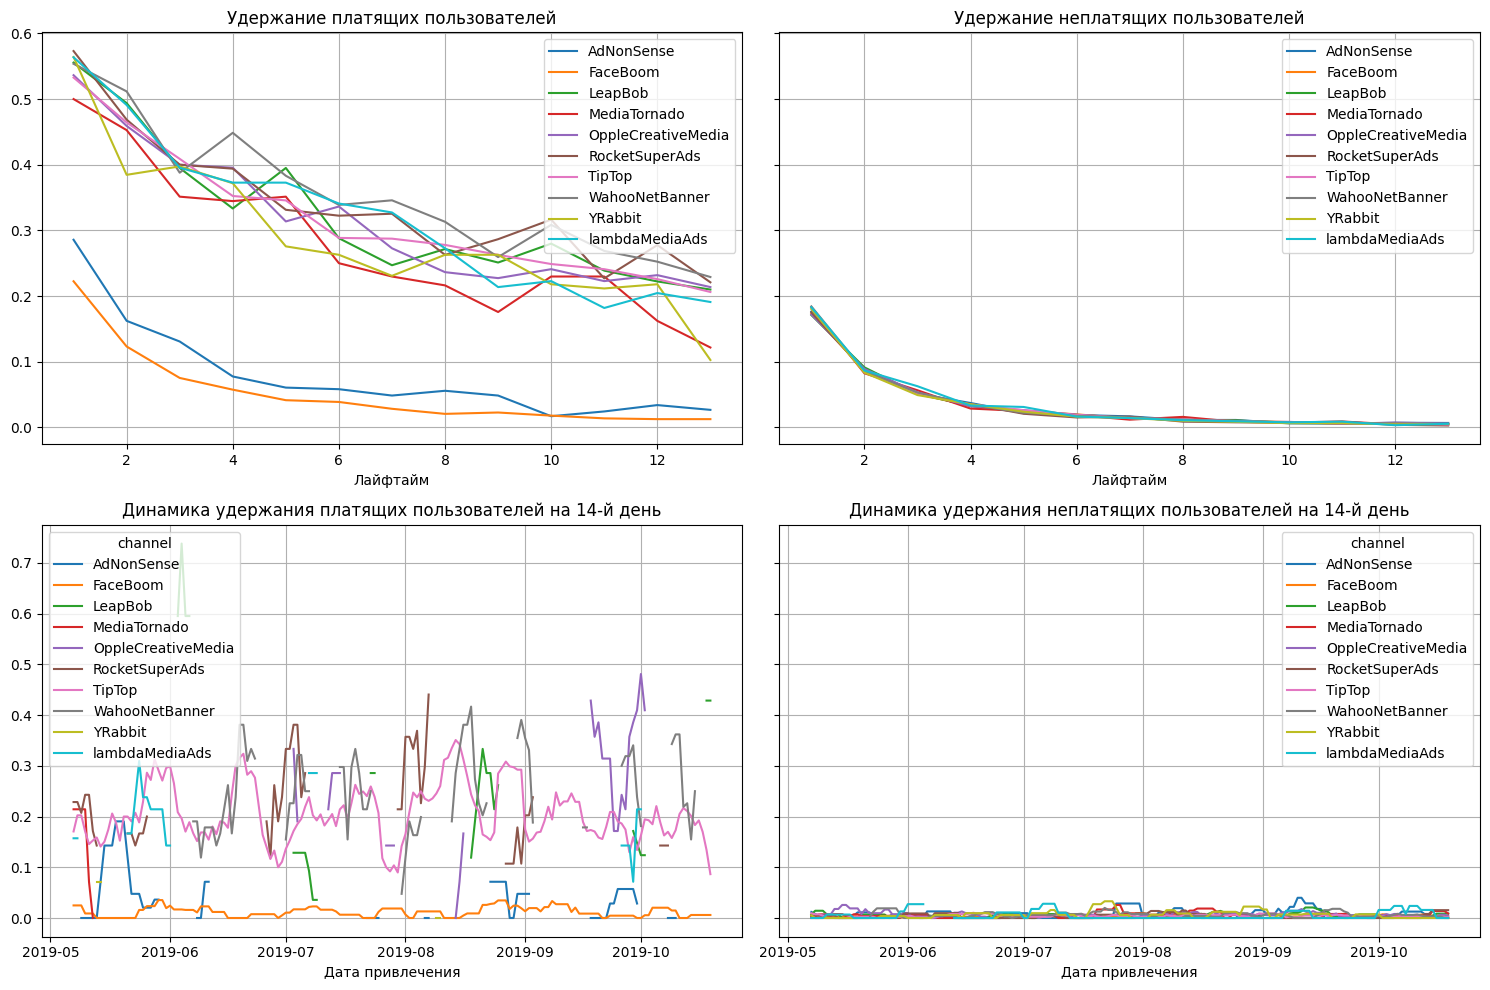

In [102]:
# смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Ситуация для всех каналов схожа, кроме FaceBoom и AdNonSense - удержание платящих пользователей, привлеченных из перечисленных источников стремительно падает, на протяжении всех 14 дней ниже, чем у пользователей из других каналов.

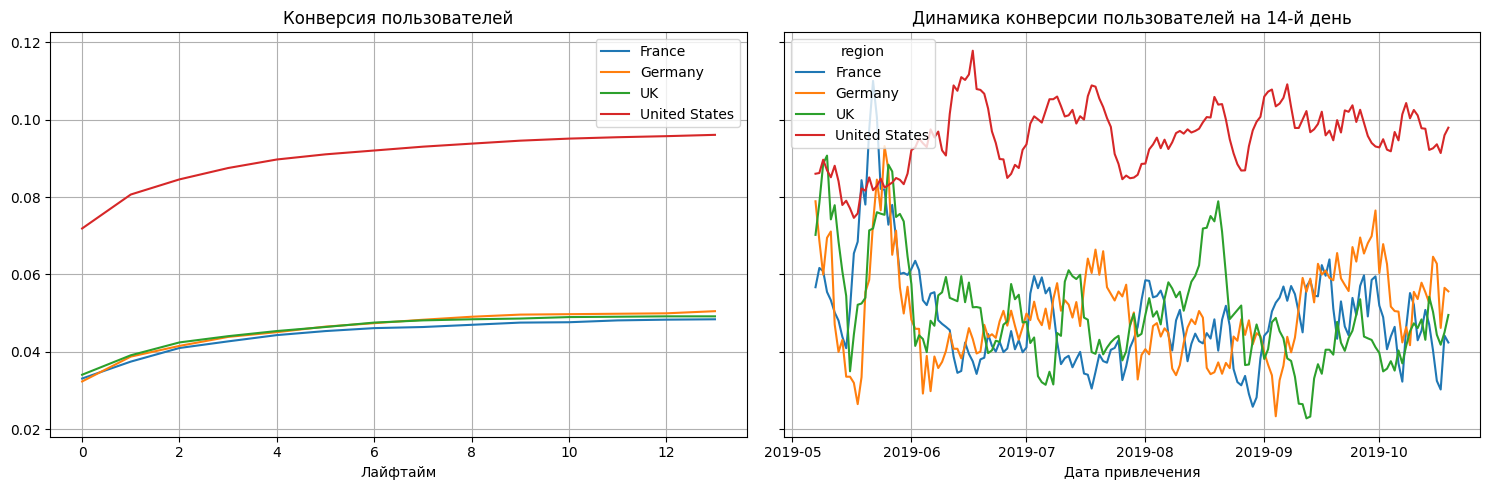

In [103]:
# смотрим конверсию с разбивкой по странам
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Наилучшая конверсия у пользователей из Соединенных Штатов.

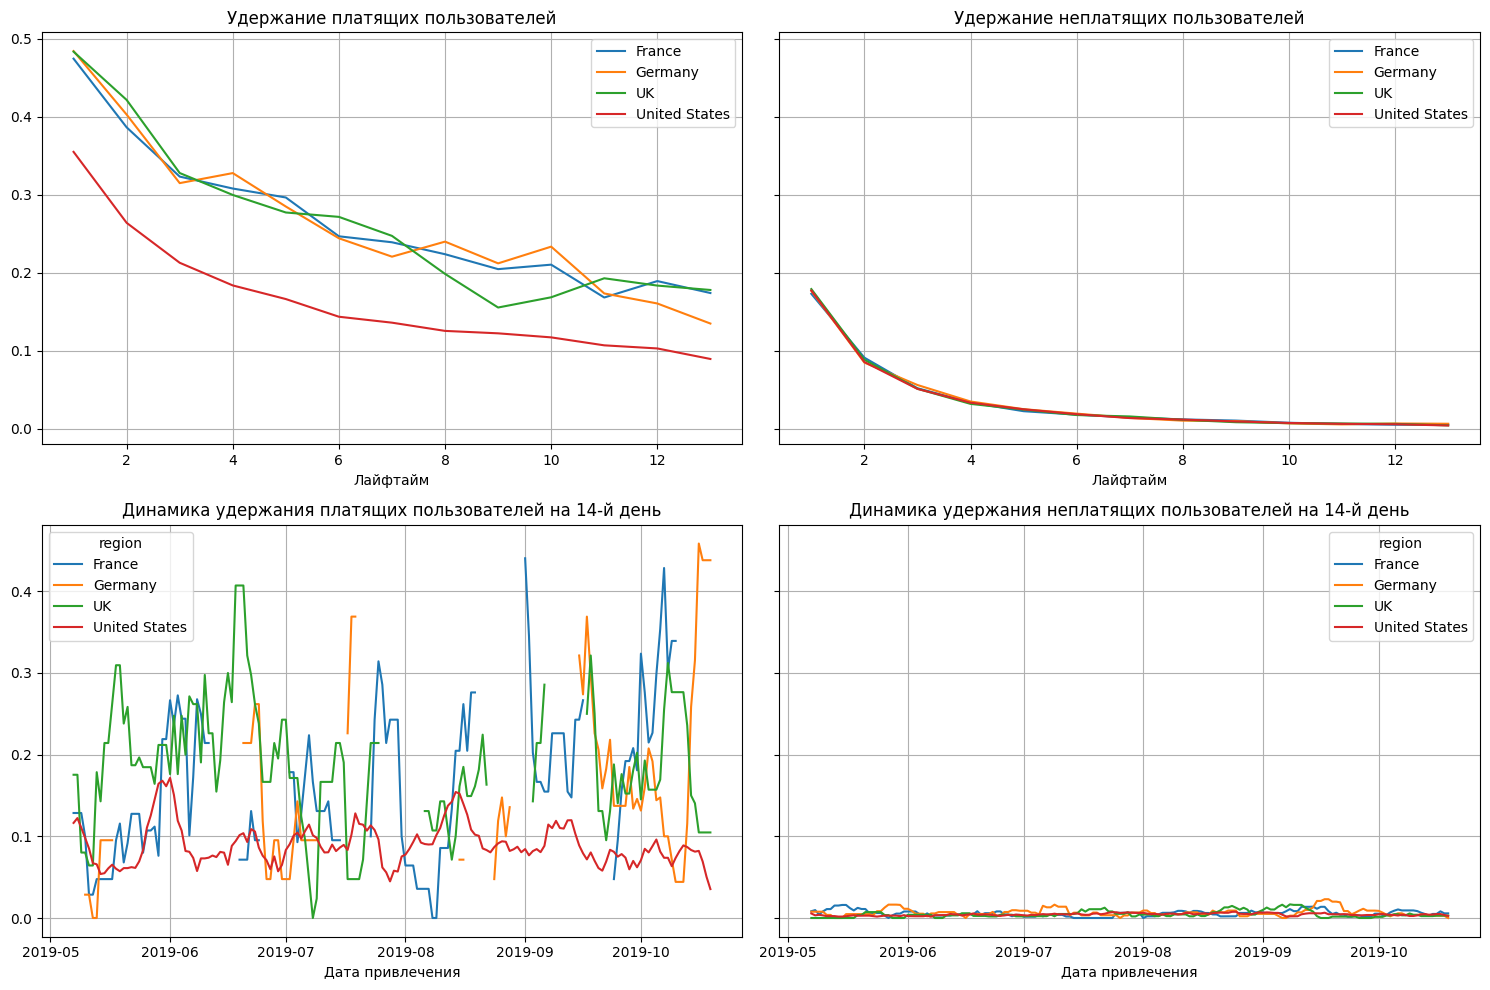

In [104]:
# смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

В то время, как удержание платящих пользователей из США уступает пользователям из других стран.

#### Проанализируем окупаемость рекламы с разбивкой по устройствам.

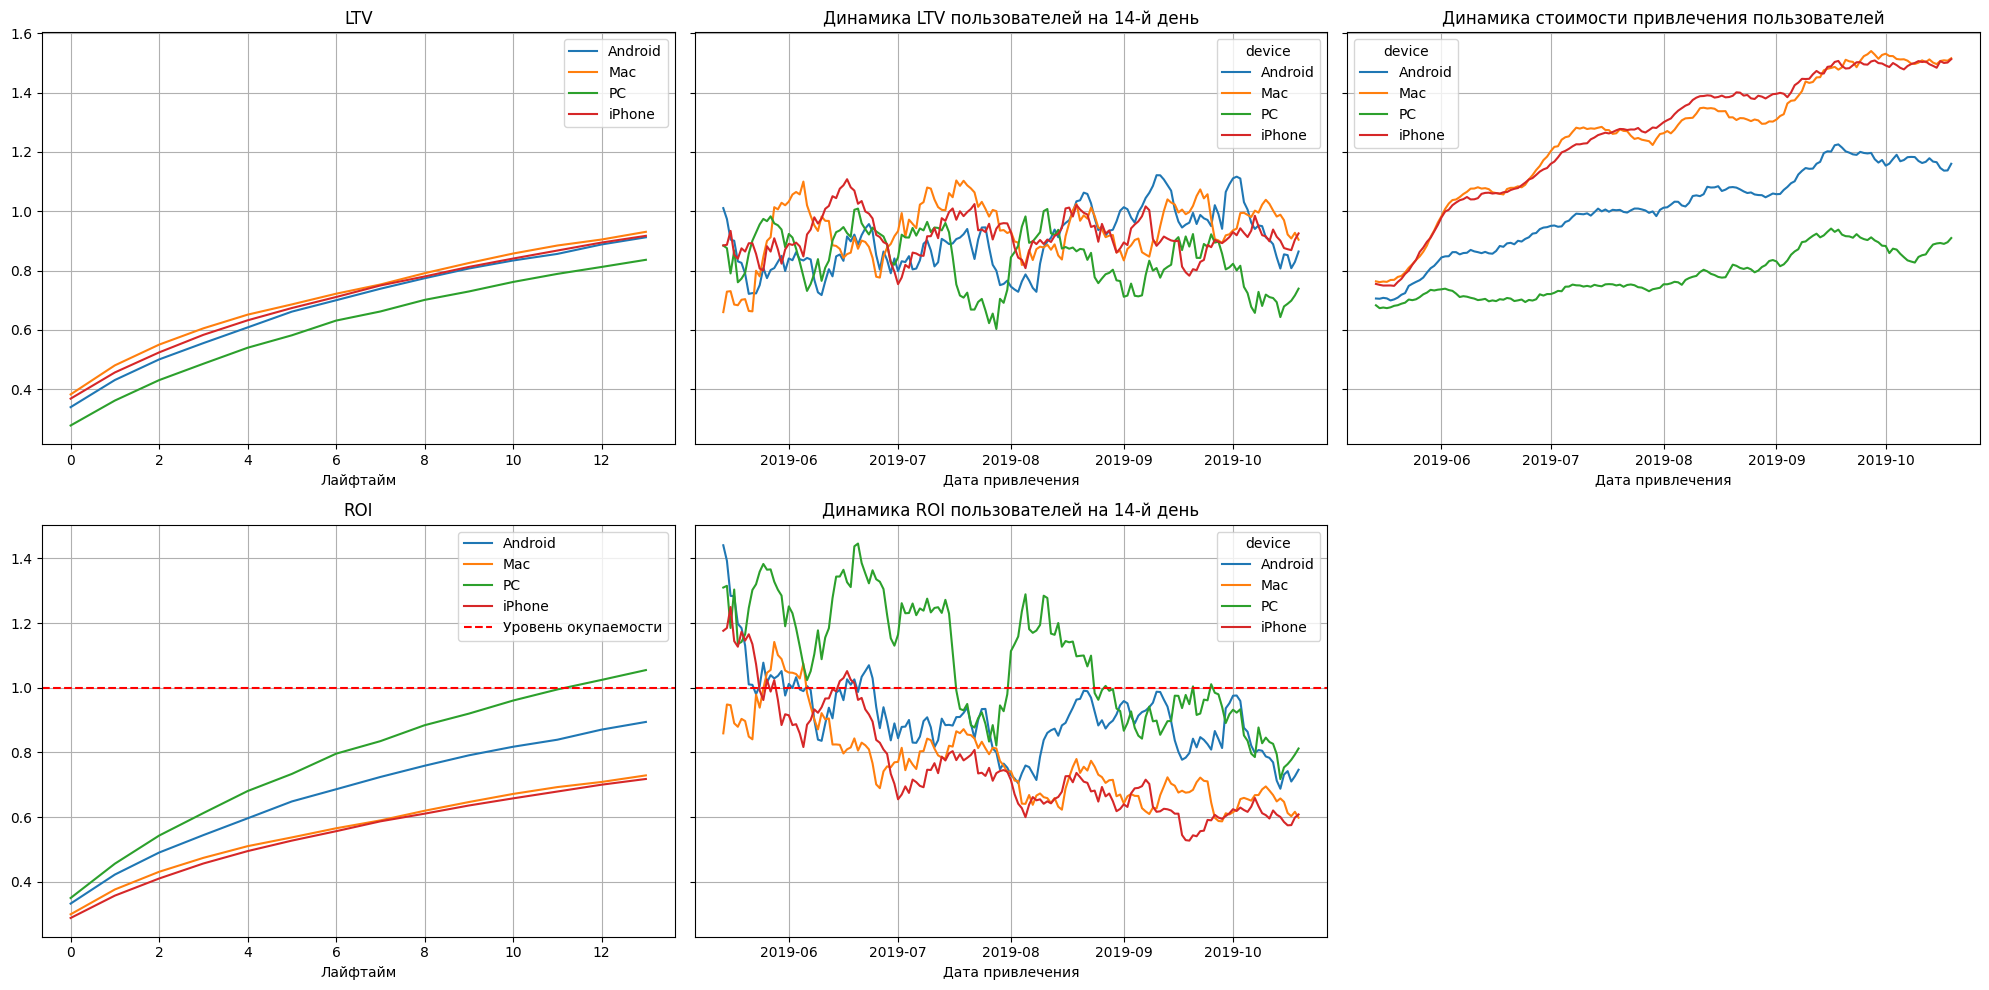

In [105]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Наибольшая стоимость привлечения для пользователей iPhone и Mac, при том, что пользователи, использующие эти устройства не окупаются. Окупаемость пользователей Android в конце второй чуть выше 80%, в том же периоде возрастает окупаемость пользователей PC и достигает ~105%.

#### Проанализируем окупаемость рекламы с разбивкой по странам. 

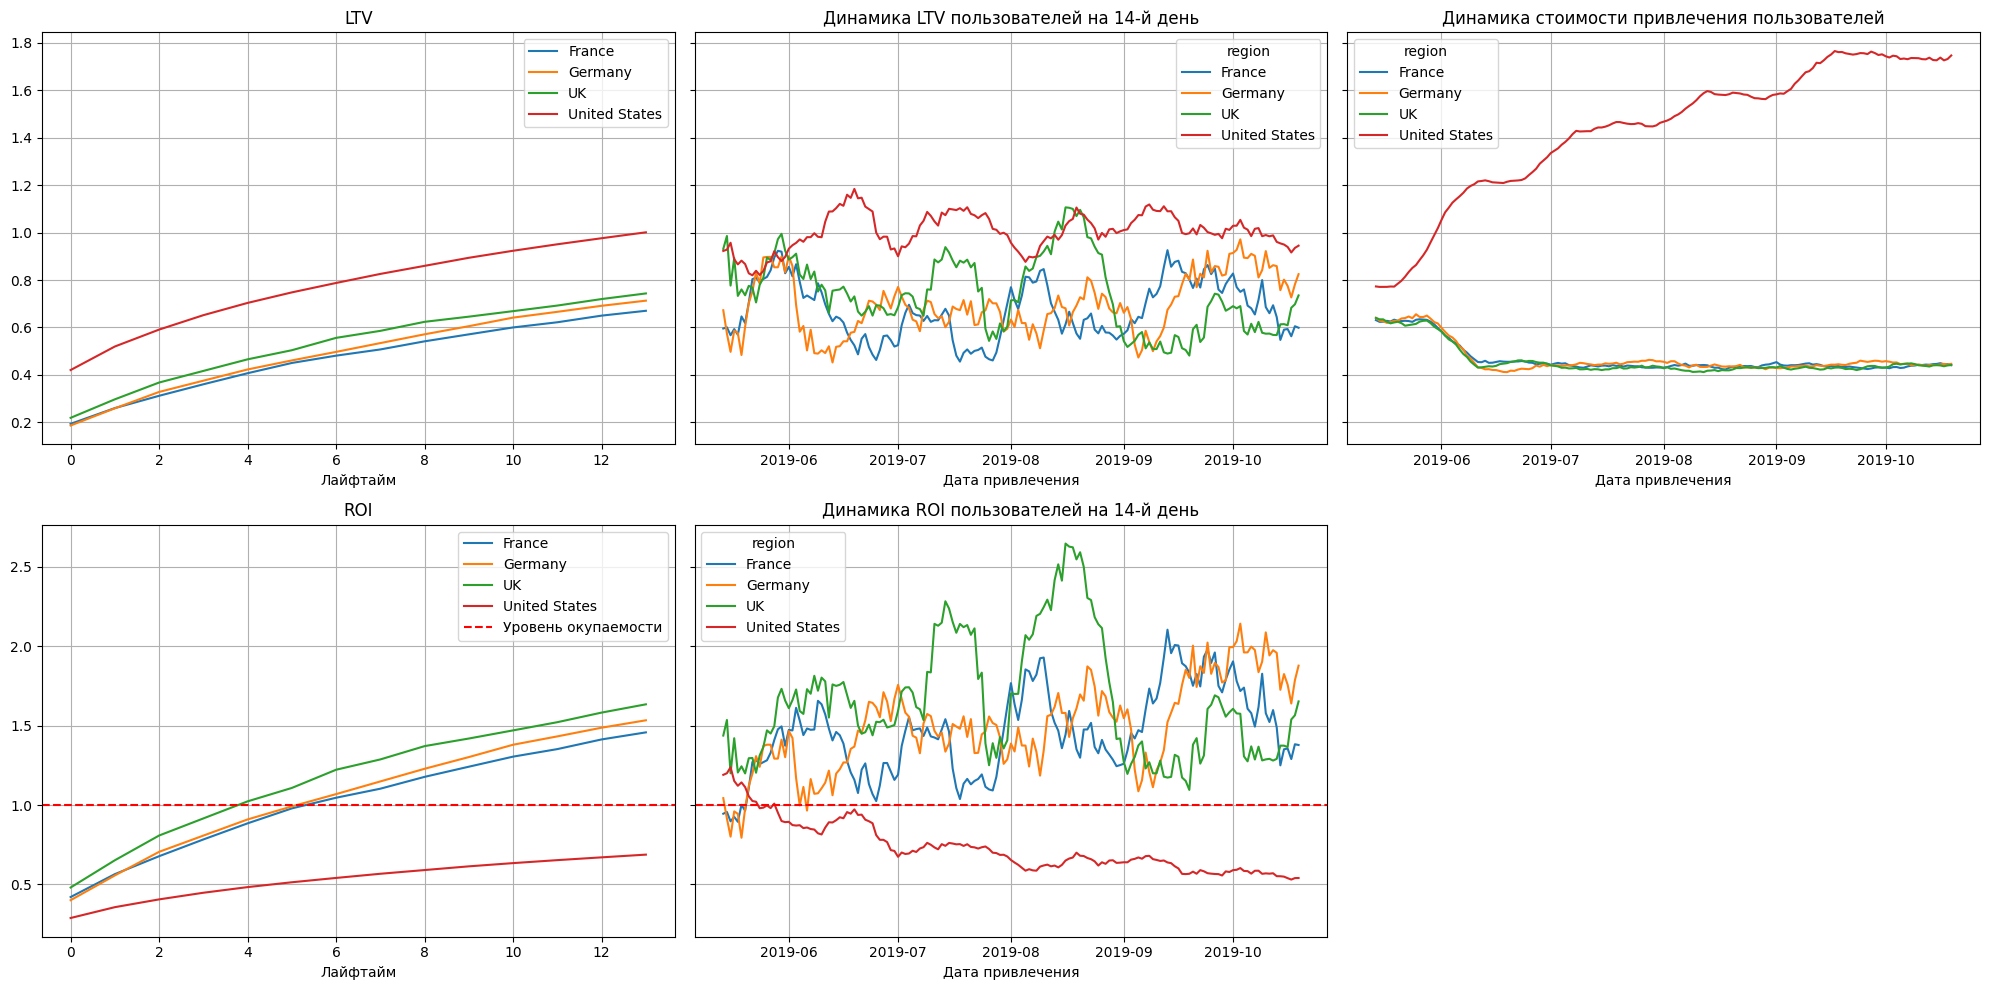

In [106]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Подробнее изучим рекламу в США:

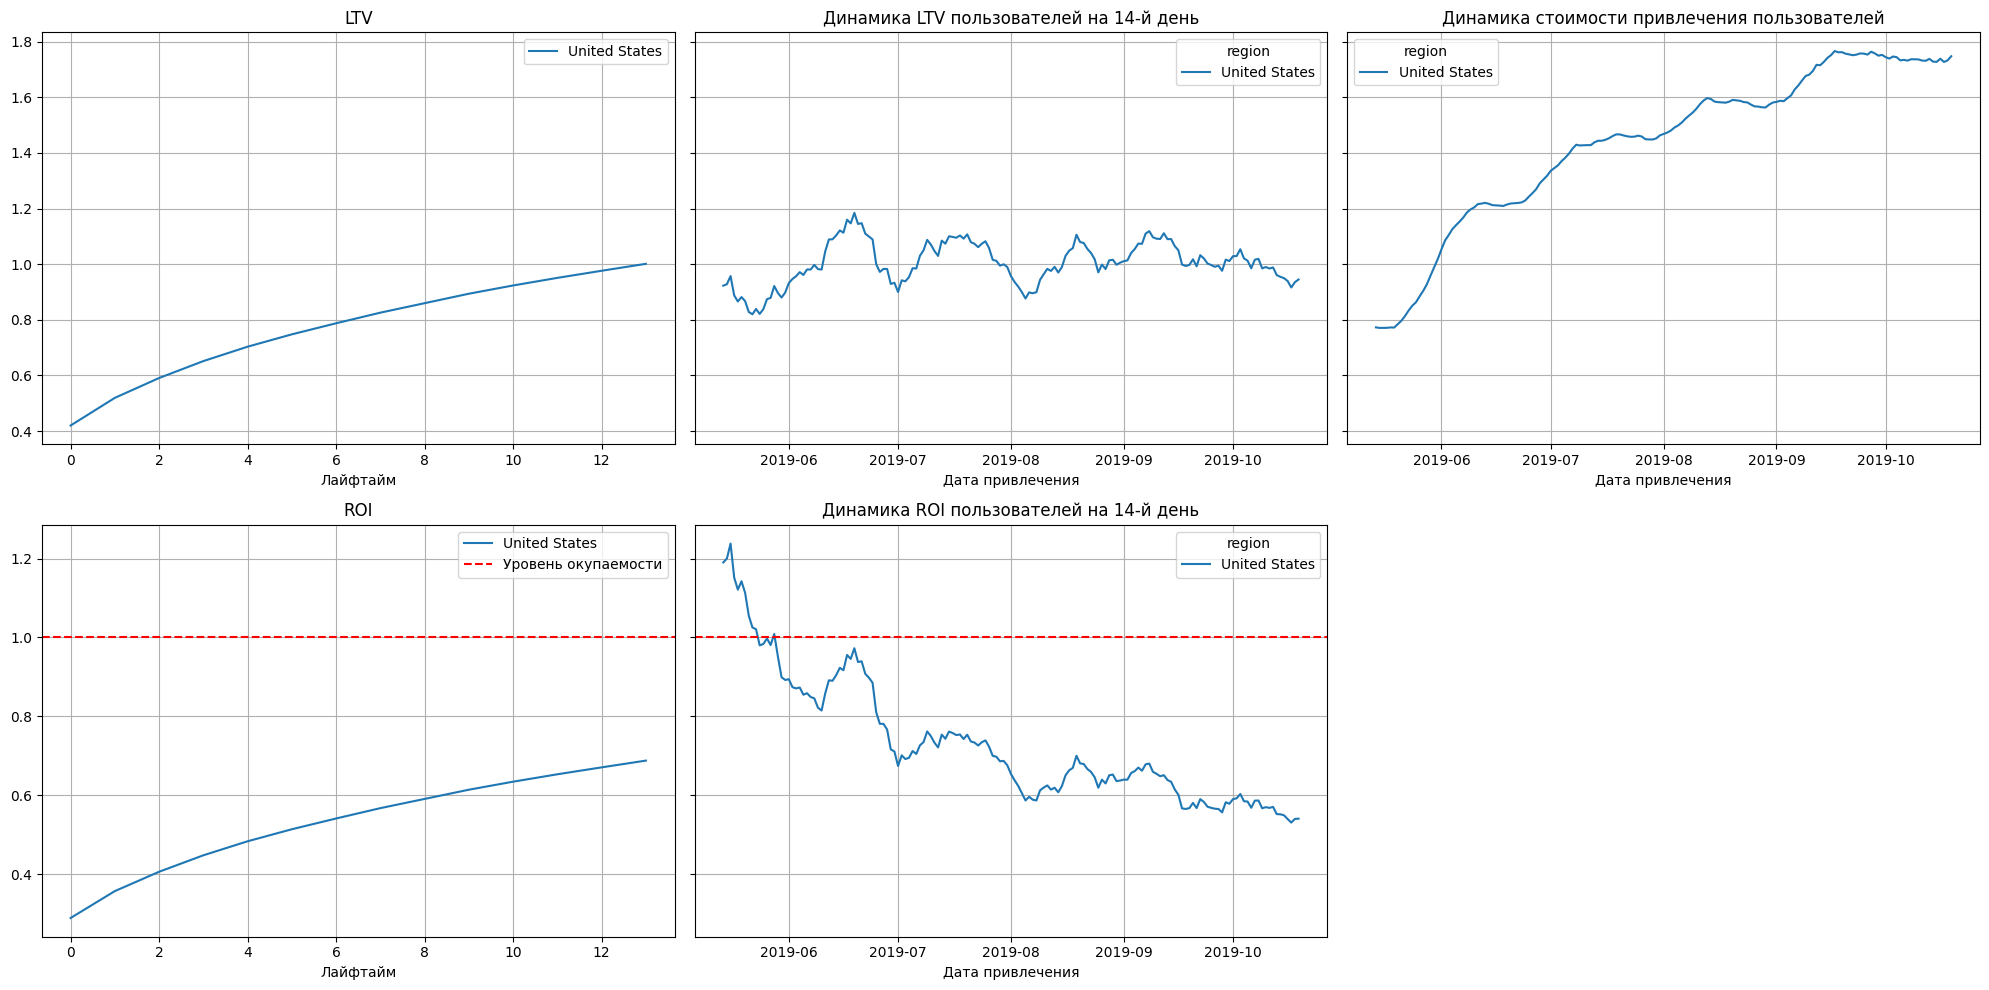

In [107]:
# исключим из таблицы все страны, кроме США
profiles_USA = profiles.query('region == "United States"')
# смотрим окупаемость для США
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_USA, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Что говорят графики:


- Реклама  в США не окупается.
- При этом, стоимость привлечения  для США значительно больше, чем для других стран, а для Германии, Великобритании и Франции стабильна и одинакова.
- LTV всё так же подвержен сезонности, но стабилен.
- Лучше всего окупается Великобритания, чуть хуже Германия и Франция, США явно отстает.

#### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. 


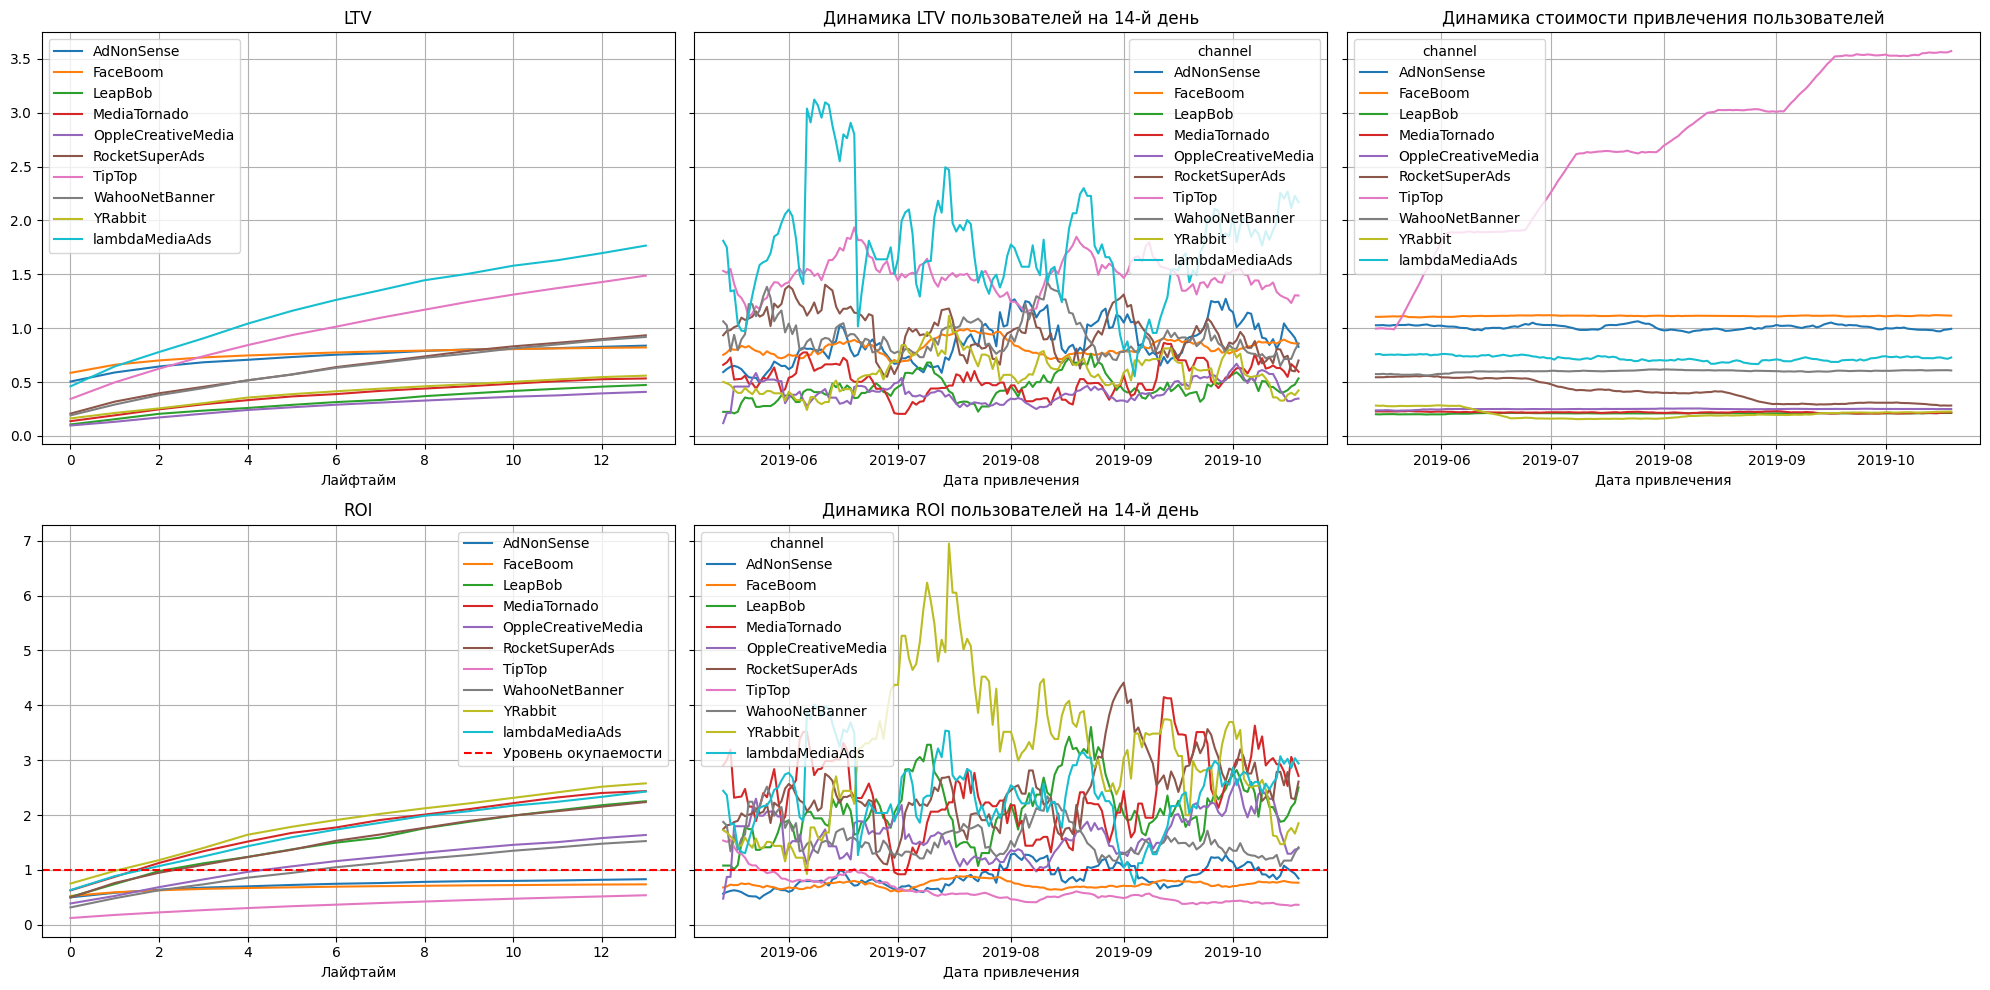

In [108]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 


Наиболее высокая динамика привлечения пользователей у канала Tip Top, но высокий уровень расходов на привлечение не привел к окупаемости, так же не окупаются пользователи, привлеченные из каналов FaceBoom и AdNonSense. Динамика привлечения остальных каналов стабильна приводит к окупаемости, наибольшую выручку приносят пользователи канала YRabbit.

Исходя из проведенного нами анализа:
- В целом, реклама, направленная направленная на привлечение пользователей, не окупается.
- Реклама  в США не окупается. При этом, стоимость привлечения  для США значительно больше, чем для других стран. Аналогично для пользователей iPhone и Mac. Наиболее высокая динамика привлечения пользователей у канала Tip Top, но высокий уровень расходов на привлечение не привел к окупаемости, так же не окупаются пользователи, привлеченные из каналов FaceBoom и AdNonSense. 
- Проблемы окупаемости могут быть связаны с завышенными ожиданиями пользователей от приложения, возможно, дополнительные расходы для пользования какими-либо функциями приложения. Возможны технические сбои в работе приложения.






### Вывод

Нами был проведен анализ данных о пользователях приложения Procrastinate Pro+ из США, Великобритании, Германии и Франции.


В ходе исследования определили:

- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

Нами было определено, что в целом реклама не окупилась. Исследование показало, что причиной обнаруженных проблем являются: 
- Чрезмерные расходы на привлечение пользователей. Так, например, пользователей из США 100002, что в 10 раз больше, чем в остальных **странах** и составляет ~76%; по количеству платящих пользователей из эта страна так же опережает. Однако реклама в США не окупается. При этом, стоимость привлечения для США значительно больше, чем для других стран, а для Германии, Великобритании и Франции стабильна и одинакова. LTV подвержен сезонности, но стабилен. 

- В основном, пользователи используют **устройства** на Android (35032 пользователей), вторые по количеству - пользователи с Mac устройствами(30042), за ними следуют пользователи с PC(30455), меньше всего приложение используют с iPhone. При этом, покупательская способность пользователей в зависимости от устройств, отличается от выше указанного распределения: наибольшее число покупок совершают пользователи с устройств Mac (6%), примерно столько же покупок происходит с iPhone, чуть меньше покупок совершают пользователи Android устройств и минимальная доля платящих пользователей используют PC устройства. При всем этом расходвы на рекламу окупаются лишь для пользователей PC.

- В распределении по **каналам**: более половины рекламного бюждета компания тратит на источник TipTop (54751.30), затраты на привлечение одного пользователя дагнного канала более чем в 2 раза превышает затраты на привлечения пользователя из других каналов. Несмотря на высокую динамику привлечения пользователей TipTop, реклама не окупается. ROI в конце второй недели — чуть выше 60%. Вероятно, дело в увеличении рекламного бюджета, отмечаем рост CAC. Так же не окупаются пользователи, привлеченные из каналов FaceBoom и AdNonSense, что связано с низким уровнем удержания платящих пользователей. Динамика привлечения остальных каналов стабильна приводит к окупаемости, наибольшую выручку приносят пользователи канала YRabbit.

Проблемы с окупаемостью могут быть связаны с завышенными ожиданиями пользователей от приложения, возможно, дополнительные расходы для пользования какими-либо функциями приложения. Возможны технические сбои в работе приложения.

Рекомендация для отдела маркетинга:

- Пресмотреть содержание рекламы, возможно, стоит сделать ее более "прозрачной" для пользователей. 
- Кроме того, причиной низкой окупаемости, скорее всего, стали чрезмерные расходы на привлечение пользователей. Стоит оценить целесообразность финансовых расходы на рекламу для пользователей из США и канал TipTop в таком объеме.
- Лучше всего на момент анализа реклама окупается в Великобритания, в связи с чем, для оптимизации затрат на рекламу в США рекомендуется обратить внимание на привлечение пользователей Великобритании. 
- Наиболее перспективным каналом является YRabbit, пользователи, привлеченные из этого источника, несмотря на свою немногочисленность и низкий САС приносят компании наибольшую выручку.